Statistical Correlation or Pearson's Coefficient

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# Load dataset
df = pd.read_csv("dataset.csv")

# # Compute correlation matrix
# corr_matrix = df.corr()

# # Select correlation with popularity
# popularity_corr = corr_matrix["popularity"].sort_values(ascending=False)

# # Display correlation
# print(popularity_corr)

# # Plot heatmap
# plt.figure(figsize=(12, 6))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Feature Correlation Heatmap")
# plt.show()

In [34]:
from gensim.models import Word2Vec

# Tokenize text
df["artists_tokenized"] = df["artists"].astype(str).apply(lambda x: x.split(";"))  # Artists are ';' separated
df["track_tokenized"] = df["track_name"].astype(str).apply(lambda x: x.split())
df["album_tokenized"] = df["album_name"].astype(str).apply(lambda x: x.split())
df["track_g_tokenized"] = df["track_genre"].astype(str).apply(lambda x: x.split())

# Train Word2Vec model
w2v_model = Word2Vec(df["artists_tokenized"].tolist() + df["track_tokenized"].tolist() + df["album_tokenized"].tolist() + df["track_g_tokenized"].tolist(),
                      vector_size=50, window=5, min_count=1, workers=4)

# Function to get word2vec embeddings
def get_w2v_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return sum(vectors) / len(vectors) if vectors else [0] * model.vector_size

# Apply Word2Vec embeddings
df["artists_embedding"] = df["artists_tokenized"].apply(lambda x: get_w2v_vector(x, w2v_model))
df["track_embedding"] = df["track_tokenized"].apply(lambda x: get_w2v_vector(x, w2v_model))
df["album_embedding"] = df["album_tokenized"].apply(lambda x: get_w2v_vector(x, w2v_model))
df["track_g_embedding"] = df["track_g_tokenized"].apply(lambda x: get_w2v_vector(x, w2v_model))


In [35]:
df["explicit_encoded"] = df["explicit"].astype(int)

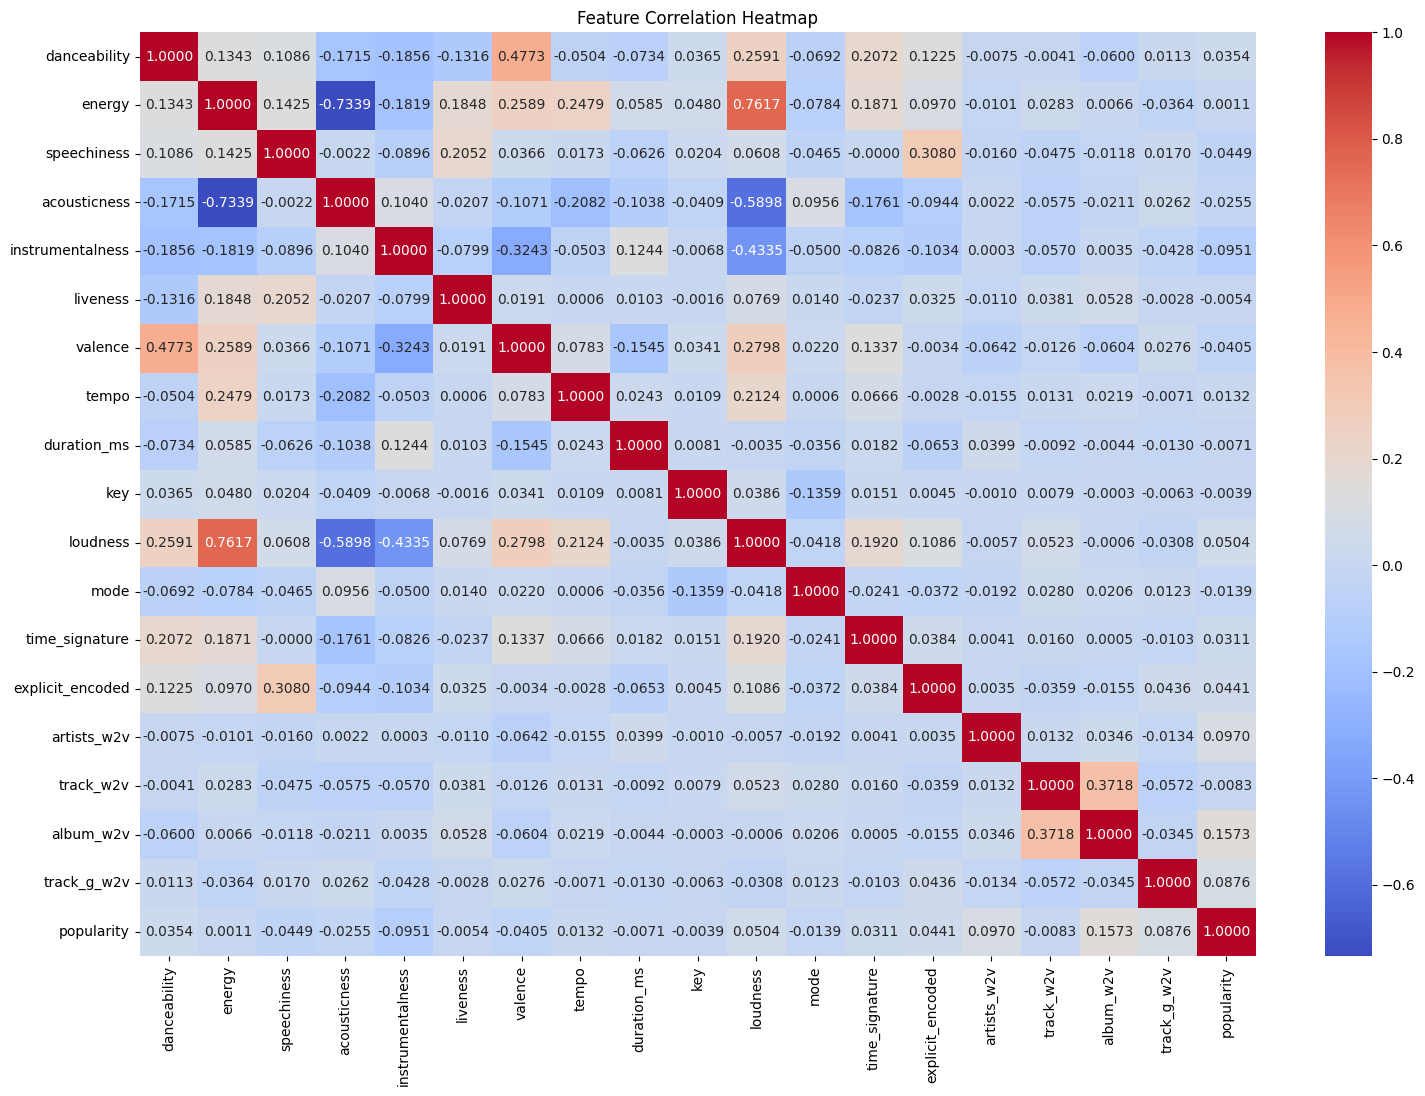

In [37]:
# Flatten embeddings
df["artists_w2v"] = df["artists_embedding"].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else 0)
df["track_w2v"] = df["track_embedding"].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else 0)
df["album_w2v"] = df["album_embedding"].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else 0)
df["track_g_w2v"] = df["track_g_embedding"].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else 0)

# Select numerical features for correlation
numerical_features = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness",
                      "liveness", "valence", "tempo", "duration_ms", "key", "loudness", "mode",
                      "time_signature", "explicit_encoded", "artists_w2v", "track_w2v", "album_w2v", "track_g_w2v"]

corr_matrix = df[numerical_features + ["popularity"]].corr()

# Plot heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'artists_tokenized', 'track_tokenized',
       'album_tokenized', 'track_g_tokenized', 'artists_embedding',
       'track_embedding', 'album_embedding', 'track_g_embedding',
       'explicit_encoded', 'artists_w2v', 'track_w2v', 'album_w2v',
       'track_g_w2v'],
      dtype='object')

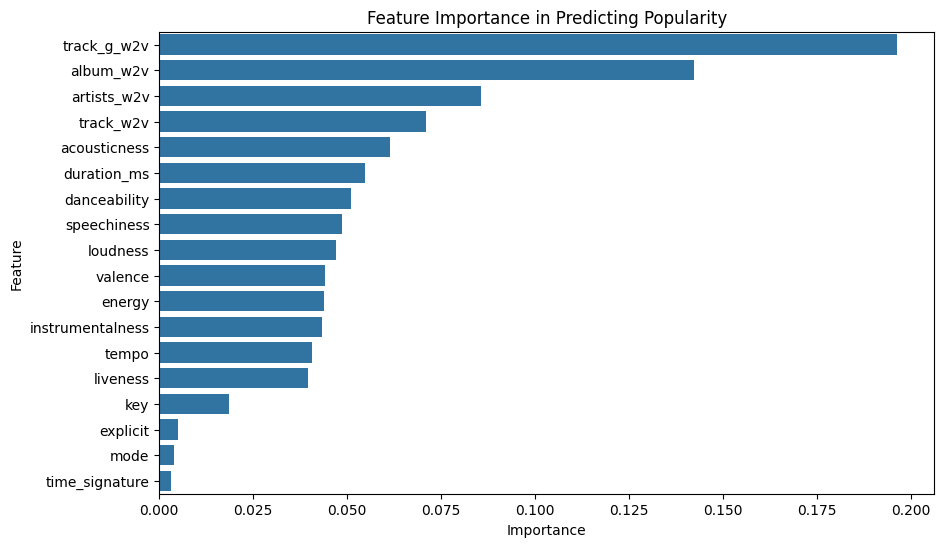

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Select numerical features (excluding categorical ones)
feature_cols = ['danceability', 'energy', 'speechiness', 'acousticness', 
                'instrumentalness', 'liveness', 'valence', 'tempo', 
                'duration_ms', 'key', 'loudness', 'mode', 'time_signature', 'explicit',
                'artists_w2v', 'album_w2v', 'track_w2v', 'track_g_w2v']
X = df[feature_cols]
y = df["popularity"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Extract feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Feature Importance in Predicting Popularity")
plt.show()

In [8]:
X_train.columns

Index(['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'key', 'loudness', 'mode', 'time_signature', 'explicit', 'artists_w2v',
       'album_w2v', 'track_w2v', 'track_g_w2v'],
      dtype='object')

In [9]:
from sklearn.model_selection import train_test_split

# Define input features (all numerical columns except 'popularity' and 'track_id')
input_features = [col for col in df.columns if col not in ['popularity', 'track_id']]

# Define target variable
X = df[input_features]
y = df['popularity']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.columns)  # Should include artist_w2v_0, artist_w2v_1, ..., track_w2v_0, etc.

Index(['Unnamed: 0', 'artists', 'album_name', 'track_name', 'duration_ms',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre',
       'artists_tokenized', 'track_tokenized', 'album_tokenized',
       'track_g_tokenized', 'artists_embedding', 'track_embedding',
       'album_embedding', 'track_g_embedding', 'explicit_encoded',
       'artists_w2v', 'track_w2v', 'album_w2v', 'track_g_w2v'],
      dtype='object')


audio_characteristics MAE: 11.292663382394503
vocal_instrumental MAE: 11.565206870959905
musical_composition MAE: 18.712886532958645
metadata_identity MAE: 9.615693599101922
duration_popularity MAE: 15.938789736269774


C:\Users\Yashsinh Patil\AppData\Local\Temp\ipykernel_20984\1384820749.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MAE", y="Feature Group", data=mae_df, palette="coolwarm")


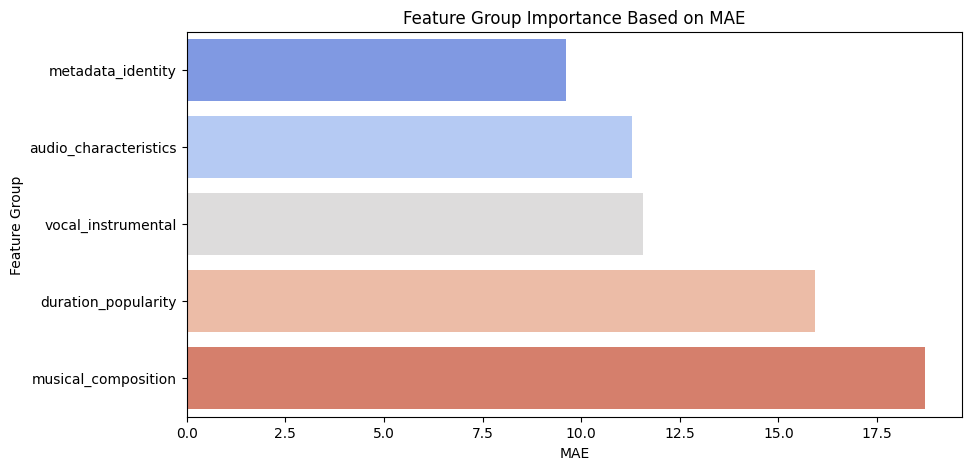

In [10]:
from sklearn.metrics import mean_absolute_error

# Define feature groups
feature_groups = {
    "audio_characteristics": ['danceability', 'energy', 'valence', 'tempo', 'loudness'],
    "vocal_instrumental": ['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'explicit'],
    "musical_composition": ['key', 'mode', 'time_signature'],
    "metadata_identity": ['track_w2v', 'album_w2v', 'artists_w2v', 'track_g_w2v'],
    "duration_popularity": ['duration_ms']
}

# Store MAE results
mae_results = {}
# Train models for each group
for group_name, features in feature_groups.items():
    X_train_group = X_train[features]
    X_test_group = X_test[features]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_group, y_train)

    y_pred_group = model.predict(X_test_group)
    mae = mean_absolute_error(y_test, y_pred_group)

    mae_results[group_name] = mae
    print(f"{group_name} MAE: {mae}")

# Convert MAE results to DataFrame
mae_df = pd.DataFrame(mae_results.items(), columns=["Feature Group", "MAE"])
mae_df = mae_df.sort_values(by="MAE", ascending=True)

# Plot MAE comparison
plt.figure(figsize=(10, 5))
sns.barplot(x="MAE", y="Feature Group", data=mae_df, palette="coolwarm")
plt.title("Feature Group Importance Based on MAE")
plt.show()


In [15]:
import numpy as np

# Example importance scores (replace these with actual MAE-based importances)
feature_importance = {
    "audio_characteristics": 11.292663382394503,
    "vocal_instrumental": 11.565206870959905,
    "musical_composition": 18.712886532958645,
    "metadata_identity": 9.615693599101922,
    "duration_popularity": 15.938789736269774
}

# Normalize the importance scores
total_importance = sum(feature_importance.values())
feature_importance = {k: v / total_importance for k, v in feature_importance.items()}
print("Normalized Feature Importance:", feature_importance)


Normalized Feature Importance: {'audio_characteristics': 0.1682327446713508, 'vocal_instrumental': 0.17229296833790803, 'musical_composition': 0.27877571088067454, 'metadata_identity': 0.14325004397258878, 'duration_popularity': 0.23744853213747777}


In [16]:
# Create new weighted feature columns
for group_name, features in feature_groups.items():
    df[group_name] = df[features].mean(axis=1) * feature_importance[group_name]

df

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,explicit_encoded,artists_w2v,track_w2v,album_w2v,track_g_w2v,audio_characteristics,vocal_instrumental,musical_composition,metadata_identity,duration_popularity
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.000169,0.016392,0.016392,0.000542,2.793437,0.018373,0.464626,0.001200,54771.303114
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,0,0.001546,0.144252,0.067638,0.000542,2.056040,0.037949,0.557551,0.007663,35524.674893
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,0,0.002910,0.130552,0.130552,0.000542,2.271647,0.013187,0.464626,0.009474,50060.324236
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,0,0.000525,0.139831,0.123190,0.000542,5.507725,0.036987,0.371701,0.009458,47948.694440
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,0,-0.000505,0.266466,0.266466,0.000542,3.751456,0.02083,0.650477,0.019087,47217.352961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,0,0.001714,0.146057,0.041303,0.001551,3.702564,0.058459,1.022178,0.006827,91417.447424
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,0,0.001714,0.092182,0.041303,0.001551,2.262629,0.072883,0.371701,0.004897,91417.684873
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,0,0.001640,0.019650,0.279388,0.001551,4.144716,0.034214,0.371701,0.010824,64459.203225
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,0,0.000483,0.082399,0.201133,0.001551,4.258879,0.023456,1.115103,0.010227,67409.976134


In [17]:
from sklearn.model_selection import train_test_split

# Define input features as only grouped features
grouped_features = list(feature_groups.keys())  # ['audio_characteristics', 'vocal_instrumental', ...]

# Define target variable
X = df[grouped_features]  # Use only grouped features for training
y = df['popularity']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify split
print(X_train.columns)  # Should match grouped_features


Index(['audio_characteristics', 'vocal_instrumental', 'musical_composition',
       'metadata_identity', 'duration_popularity'],
      dtype='object')


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Train model using only grouped features
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
print(f"Final Model MAE: {mae}")


Final Model MAE: 12.632318450814536


In [39]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 12.632318450814536
Root Mean Squared Error (RMSE): 16.447911826553202
R² Score: 0.4517846353748959


In [29]:
df.columns
#df.drop(['artists','album_name','track_name','track_genre','artists_tokenized','album_tokenized','track_tokenized','track_g_tokenized','artists_embedding','album_embedding','track_embedding','track_g_embedding'])
df = df.drop(columns=['artists','album_name','track_name','track_genre',
                      'artists_tokenized','album_tokenized','track_tokenized','track_g_tokenized',
                      'artists_embedding','album_embedding','track_embedding','track_g_embedding'],
             errors='ignore')


In [ ]:
df.to_csv('spotify_modded.csv', encoding='utf-8', index=False)  

In [41]:
import joblib
joblib.dump(model, "spotify_popularity_model.pkl")

['spotify_popularity_model.pkl']

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define a threshold (e.g., popularity > 50 is "popular", else "not popular")
threshold = 50
y_test_class = (y_test > threshold).astype(int)   # Actual classes
y_pred_class = (y_pred.flatten() > threshold).astype(int)   # Predicted classes

# Compute classification metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.82
Precision: 0.92
Recall: 0.28


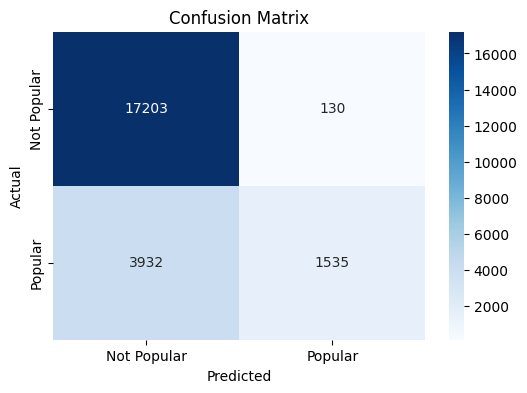

In [48]:
# Compute confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Popular", "Popular"], yticklabels=["Not Popular", "Popular"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

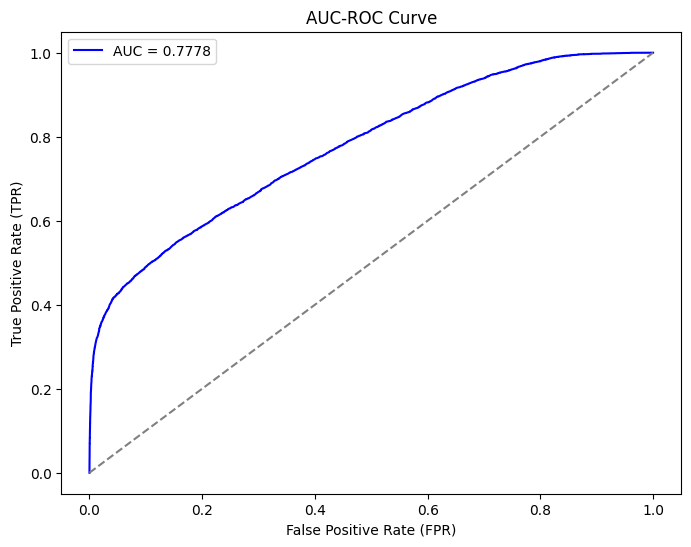

AUC Score: 0.7778


In [49]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_class, y_pred.flatten())  # Use predicted scores, not binary labels
auc_score = roc_auc_score(y_test_class, y_pred.flatten())

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal (random guess)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("AUC-ROC Curve")
plt.legend()
plt.show()

print(f"AUC Score: {auc_score:.4f}")


In [50]:
gini = 2*auc_score - 1
gini

0.5556361619468468